# Principe

On va appliquer une méthode de classification par machine learning pour essayer de classifier l'état des stations vélib en 5 catégories : 
 - 0 : très faible occupation : risque élevé de ne pas pouvoir retirer un vélo
 - 1 : faible occupation : risque faible de ne pas pouvoir retirer un vélo
 - 2 : occupation moyenne : pas de problème prévu
 - 3 : forte occupation : risque faible de ne pas pouvoir déposer un vélo
 - 4 : très forte occupation : risque élevé de ne pas pouvoir déposer un vélo

On s'inspirera pour ce faire de la méthode de classification vue en cours à l'aide de RandomForestClassifier.



# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
# import re
import random
# import pickle
import data.datasets as dst


In [57]:
import sklearn as skl
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix

# Chargement des données, et prétraitement : 

In [41]:
df1 = dst.getDataset("2023_03_18")
df2 = dst.getDataset("2023_03_19")
df3 = dst.getDataset("2023_03_20")

In [63]:
df = pd.concat([df1.iloc[0::10,:], df2.iloc[0::10,:], df3.iloc[0::10,:]])
#df = df1.copy()
df

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,weekday,hour,name,lat,lon,capacity,occupation_prct,occupation_class,seconds_since_midnight
0,213688169,1,0.0,1.0,34,1,1,1,1679092047,2023-03-18 00:00:53,5,00:00:53,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,2.857143,0,53
10,213688169,1,0.0,1.0,34,1,1,1,1679092047,2023-03-18 00:20:55,5,00:20:55,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,2.857143,0,1255
20,213688169,2,1.0,1.0,33,1,1,1,1679095761,2023-03-18 00:40:56,5,00:40:56,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,5.714286,1,2456
30,213688169,3,2.0,1.0,32,1,1,1,1679095761,2023-03-18 01:00:57,5,01:00:57,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,8.571429,1,3657
40,213688169,6,3.0,3.0,29,1,1,1,1679095211,2023-03-18 01:20:59,5,01:20:59,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857,1,4859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039560,315022587,1,1.0,0.0,63,1,1,1,1679344275,2023-03-20 22:17:55,0,22:17:55,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537,0,80275
1039570,315022587,2,1.0,1.0,62,1,1,1,1679347756,2023-03-20 22:37:56,0,22:37:56,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,2.985075,0,81476
1039580,315022587,0,0.0,0.0,64,1,1,1,1679347756,2023-03-20 22:57:57,0,22:57:57,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,0.000000,0,82677
1039590,315022587,0,0.0,0.0,64,1,1,1,1679347756,2023-03-20 23:18:59,0,23:18:59,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,0.000000,0,83939


# Méthode de base, sans occupation aux temps précédents

## Principe

Cette prédiction ne pourrait utiliser que les éléments qui seront connus au moment de la prédiction, soit le lieu, le temps, etc, mais pas le nombre de vélos disponibles. 
Si on veut utiliser ce dernier, il faudrait rajouter la valeur à un temps passé, ce qu'on pourra faire dans la prochaine étape si les données actuelles ne donnent pas de bons résultats. 

## Définition des features et target

In [54]:
df.head(1)

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,weekday,hour,name,lat,lon,capacity,occupation_prct,occupation_class,seconds_since_midnight
0,213688169,1,0.0,1.0,34,1,1,1,1679092047,2023-03-18 00:00:53,5,00:00:53,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,2.857143,0,53


In [55]:
# feat=['station_id', 'capacity', 'seconds_since_midnight']
feat=["station_id", "lat", "lon", "seconds_since_midnight"]
target=["occupation_class"]

x=df[feat]
y=df[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Pour information, l'ensemble d'entrainement contient les classes dans les proportions suivantes:

In [56]:
for i in set(y.values[:,0]) :
    print(i, len(y[y.occupation_class == i]))

0 125642
1 348838
2 405622
3 136569
4 28755


## Entrainement et prédiction

In [64]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(x_train, y_train.values.ravel())

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [65]:
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.4975560295763466

In [66]:
print(feat)
clf.feature_importances_

['station_id', 'lat', 'lon', 'seconds_since_midnight']


array([0.15153262, 0.4853145 , 0.31945374, 0.04369914])

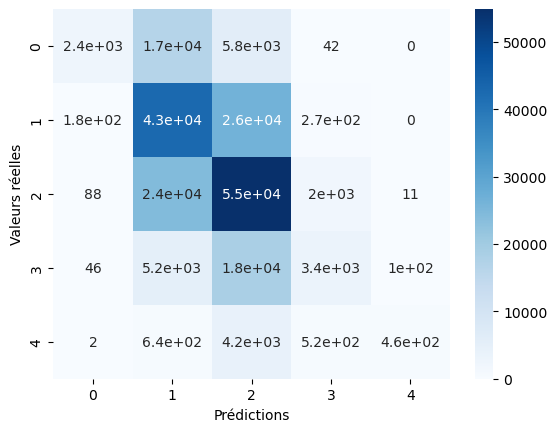

In [67]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

In [68]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.10      0.18     25031
           1       0.48      0.61      0.54     69695
           2       0.50      0.67      0.57     81295
           3       0.54      0.13      0.20     27274
           4       0.80      0.08      0.14      5791

    accuracy                           0.50    209086
   macro avg       0.64      0.32      0.33    209086
weighted avg       0.55      0.50      0.45    209086



# Méthode avec la valeur d'occupation à un temps précédent

## Principe

Je vais rajouter le taux d'occupation quelques heures avant le temps de prédiction. Je prendrais 6 heures pour commencer.

Pour simplifier, je prend juste la valeur à minuit pour les temps avant 6h du matin, au lieu de charger les valeurs de la veille.

In [13]:
df2=df.copy()
# df2.loc[df2['seconds_since_midnight'] > 6*3600.,'old_occupancy_class']=
df3=df2[['time','station_id','occupation_class']].copy()
df3['time']=df3['time']+pd.Timedelta(hours=6)
df3=df3.rename(columns={"time": "old_time", "occupation_class": "old_occupation_class"})
#, 'station_id' : 'old_station_id'

df2=pd.merge_asof(df2.sort_values('time'), df3.sort_values('old_time'), by='station_id', left_on='time', right_on='old_time', direction='nearest')

In [14]:
df2

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,...,hour,name,lat,lon,capacity,occupation_prct,occupation_class,seconds_since_midnight,old_time,old_occupation_class
0,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:00:18,...,00:00:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857,1,18,2023-03-20 06:00:18,1
1,653152142,11,1.0,10.0,9,1,1,1,1679264816,2023-03-20 00:00:18,...,00:00:18,Château - République,48.905928,2.253629,20,55.000000,2,18,2023-03-20 06:00:18,2
2,586539770,9,3.0,6.0,13,1,1,1,1679265054,2023-03-20 00:00:18,...,00:00:18,Marne - Germain Dardan,48.811543,2.303071,22,40.909091,2,18,2023-03-20 06:00:18,2
3,96608796,27,26.0,1.0,0,1,1,1,1679265087,2023-03-20 00:00:18,...,00:00:18,Fille du Calvaire - Turenne,48.862105,2.364960,29,93.103448,3,18,2023-03-20 06:00:18,3
4,82499609,32,27.0,5.0,3,1,1,1,1679265126,2023-03-20 00:00:18,...,00:00:18,Convention - Lourmel,48.842055,2.285991,36,88.888889,3,18,2023-03-20 06:00:18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039605,653089942,8,2.0,6.0,12,1,1,1,1679351323,2023-03-20 23:58:01,...,23:58:01,Poissonniers - Championnet,48.895433,2.353018,28,28.571429,2,86281,2023-03-20 23:58:37,1
1039606,128841079,1,1.0,0.0,35,1,1,1,1679351366,2023-03-20 23:58:01,...,23:58:01,Cambon - Rivoli,48.866143,2.325180,40,2.500000,0,86281,2023-03-20 23:58:37,2
1039607,220504949,3,2.0,1.0,27,1,1,1,1679351593,2023-03-20 23:58:01,...,23:58:01,Grande Truanderie - Saint-Denis,48.862630,2.349807,33,9.090909,1,86281,2023-03-20 23:58:37,3
1039608,41464928,17,14.0,3.0,45,1,1,1,1679351580,2023-03-20 23:58:01,...,23:58:01,Sèvres - Lecourbe,48.844768,2.311009,62,27.419355,2,86281,2023-03-20 23:58:37,1


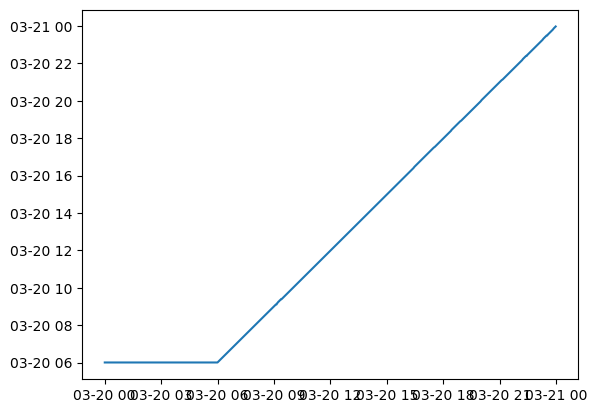

In [15]:
plt.plot(df2.time, df2.old_time)

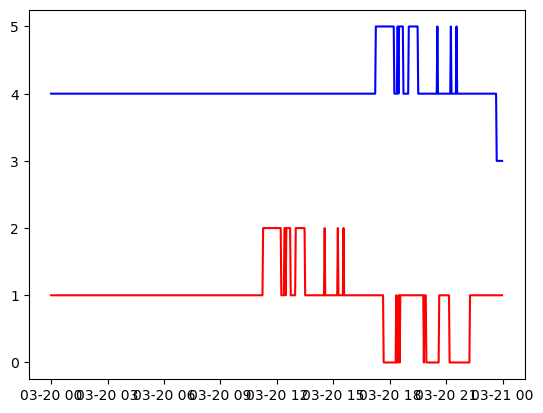

In [16]:
ind=(df2.station_id == df2.loc[0,'station_id'])

plt.plot(df2[ind].time, df2[ind].occupation_class, color='r')
plt.plot(df2[ind].time, df2[ind].old_occupation_class+3, color='b')


## Définition des features et target

In [17]:
df2.head(1)

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,...,hour,name,lat,lon,capacity,occupation_prct,occupation_class,seconds_since_midnight,old_time,old_occupation_class
0,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:00:18,...,00:00:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857,1,18,2023-03-20 06:00:18,1


In [18]:
feat=['station_id', 'seconds_since_midnight','lat', 'lon', 'old_occupation_class']
target=['occupation_class']

x=df2[feat]
y=df2[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Pour information, l'ensemble d'entrainement contient les classes dans les proportions suivantes:

In [19]:
for i in set(y.values[:,0]) :
    print(i, len(y[y.occupation_class == i]))

0 144036
1 336875
2 400476
3 130082
4 28141


## Entrainement et prédiction

In [20]:
clf2=RandomForestClassifier(max_depth=2, random_state=42)
clf2.fit(x_train, y_train.values.ravel())

RandomForestClassifier(max_depth=2, random_state=42)

In [21]:
y_pred = clf2.predict(x_test)
accuracy_score(y_test, y_pred)

0.5231625321033849

<AxesSubplot:>

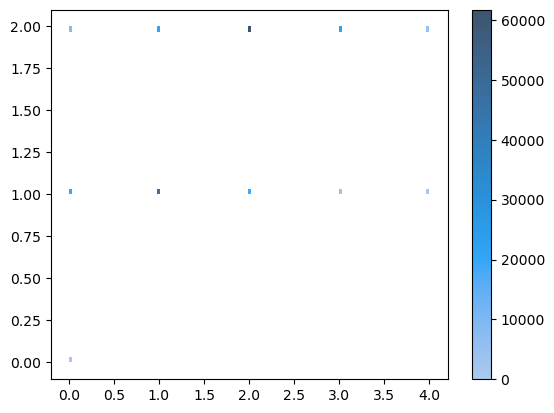

In [22]:
sns.histplot(x=y_test.values.ravel(), y=y_pred, cbar=True)

<AxesSubplot:>

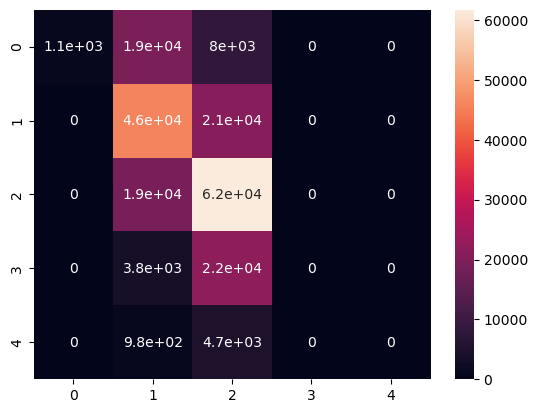

In [23]:
co=confusion_matrix(y_test.values.ravel(), y_pred)
sns.heatmap(co, annot = True)

In [160]:
print(feat)
clf2.feature_importances_

['station_id', 'seconds_since_midnight', 'lat', 'lon', 'old_occupation_class']


array([0.07836968, 0.19854182, 0.07330987, 0.01298314, 0.63679549])

# Méthode avec la valeur d'occupation à un temps précédent (cyclicité bien prise en compte)

## Principe

Je vais rajouter le taux d'occupation quelques heures avant le temps de prédiction. Je prendrais 6 heures pour commencer.

Pour simplifier, je prend juste la valeur à minuit pour les temps avant 6h du matin, au lieu de charger les valeurs de la veille.

In [191]:
df4=df.copy()
# df2.loc[df2['seconds_since_midnight'] > 6*3600.,'old_occupancy_class']=
df3=df4[['hour','station_id','occupation_class']].copy()
df4['hour']=df4['hour']+pd.Timedelta(hours=0) 
df3['hour']=df3['hour']+pd.Timedelta(hours=6)
df3['hour']=df3['hour'].apply(lambda x:x-pd.Timedelta(days=x.days))
df3=df3.rename(columns={"hour": "old_hour", "occupation_class": "old_occupation_class"})
#, 'station_id' : 'old_station_id'

In [206]:
df4=pd.merge_asof(df4.sort_values('hour'), 
                  df3.sort_values('old_hour'), 
                  by='station_id', left_on='hour', right_on='old_hour', direction='nearest')

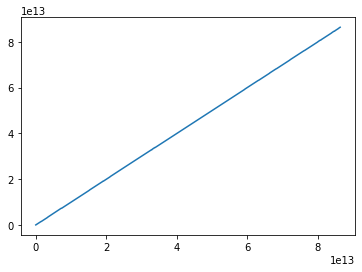

In [207]:
plt.plot(df4.hour, df4.old_hour)

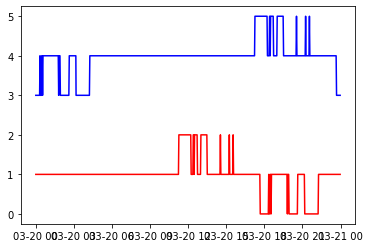

In [210]:
ind=(df4.station_id == df4.loc[0,'station_id'])

plt.plot(df4[ind].time, df4[ind].occupation_class, color='r')
plt.plot(df4[ind].time, df4[ind].old_occupation_class+3, color='b')


## Définition des features et target

In [211]:
df4.head(1)

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,...,hour,name,lat,lon,capacity,occupation_prct,seconds_since_midnight,occupation_class,old_hour,old_occupation_class
0,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:00:18,...,0 days 00:00:18,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857,18,1,0 days 00:00:37,0


In [212]:
feat=['station_id', 'seconds_since_midnight', 'old_occupation_class']
target=['occupation_class']

x=df2[feat]
y=df2[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Pour information, l'ensemble d'entrainement contient les classes dans les proportions suivantes:

In [213]:
for i in set(y.values[:,0]) :
    print(i, len(y[y.occupation_class == i]))

0 144036
1 336875
2 400535
3 130065
4 28099


## Entrainement et prédiction

In [214]:
clf4=RandomForestClassifier(max_depth=2, random_state=42)
clf4.fit(x_train, y_train.values.ravel())

RandomForestClassifier(max_depth=2, random_state=42)

In [215]:
y_pred = clf4.predict(x_test)
accuracy_score(y_test, y_pred)

0.5230663421860121

<AxesSubplot:>

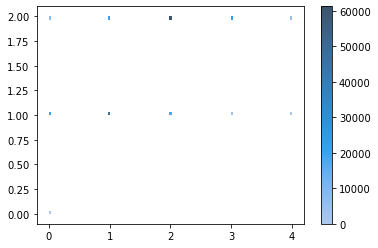

In [216]:
sns.histplot(x=y_test.values.ravel(), y=y_pred, cbar=True)

<AxesSubplot:>

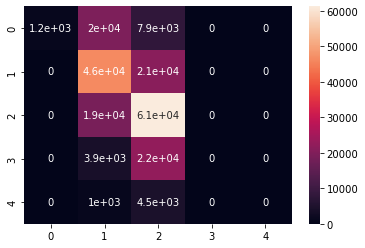

In [217]:
co=confusion_matrix(y_test.values.ravel(), y_pred)
sns.heatmap(co, annot = True)

In [218]:
print(feat)
clf4.feature_importances_

['station_id', 'seconds_since_midnight', 'old_occupation_class']


array([0.20508767, 0.29210992, 0.50280242])